In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise,data

In [2]:
%matplotlib inline
#We define a function useful to find local minimizers
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

In [3]:
#https://ourworldindata.org/coronavirus-source-data
data = pd.read_csv(r'C:\Users\javie\Covid19\datas\owid-covid-data-01-03.csv')
df =pd.DataFrame(data)
#Belgica
Blegiumdata=df.loc[df['location']=='Belgium']
Belgiumts=np.array(Blegiumdata.new_cases_per_million).astype(float)/10

#Noruega
Norwaydata=df.loc[df['location']=='Norway']
Norwayts=np.array(Norwaydata.new_cases_per_million).astype(float)[1:]/10
# Norwayts=Norwayts[3:]

#Estados Unidos
USdata=df.loc[df['location']=='United States']
USts=np.array(USdata.new_cases_per_million).astype(float)[1:]/10
# USts=USts[1:]

#Chile
Chiledata=df.loc[df['location']=='Chile']
Chilets=np.array(Chiledata.new_cases_per_million).astype(float)/10

#Dinamarca
Denmarkdata=df.loc[df['location']=='Denmark']
Denmarkts=np.array(Denmarkdata.new_cases_per_million).astype(float)[25:]/10
# [11:]
# Denmarkts=Denmarkts[14:]

#Canada
Canadadata=df.loc[df['location']=='Canada']
Canadats=np.array(Canadadata.new_cases_per_million).astype(float)/10

#Republica Checa
CzechRdata=df.loc[df['location']=='Czech Republic']
CzechRts=np.array(CzechRdata.new_cases_per_million).astype(float)/10

#Nueva Zelanda
NZdata=df.loc[df['location']=='New Zealand']
NZts=np.array(NZdata.new_cases_per_million).astype(float)/10

#Alemania
Alemaniadata=df.loc[df['location']=='Germany']
Alemaniats=np.array(Alemaniadata.new_cases_per_million).astype(float)[3:]/10

#Italia
Italydata=df.loc[df['location']=='Italy']
Italiats=np.array(Italydata.new_cases_per_million).astype(float)/10

#Solo no se encuentra republica checa, quizas con otro nombre.
#Quitamos NZ también.
#AGREGAMOS NUEVA ZELANDA, JAPON, COREA DEL SUR, AUSTRALIA.

Japandata=df.loc[df['location']=='Japan']
Japants=np.array(Japandata.new_cases_per_million).astype(float)[1:]/10
# [1:]

SKdata=df.loc[df['location']=='South Korea']
SKts=np.array(SKdata.new_cases_per_million).astype(float)[2:]/10
# [2:]

Australiadata=df.loc[df['location']=='Australia']
Australiats=np.array(Australiadata.new_cases_per_million).astype(float)/10

In [4]:
Time_series=[Belgiumts,Norwayts,
             USts,Chilets,Denmarkts, 
             Alemaniats, Italiats,
             Japants, SKts, Australiats, NZts]
Paises=['Belgica', 'Noruega', 'Estados Unidos', 'Chile', 'Dinamarca', 'Alemania', 'Italia', 'Japon', 'Corea del Sur',
       'Australia','Nueva Zelanda']

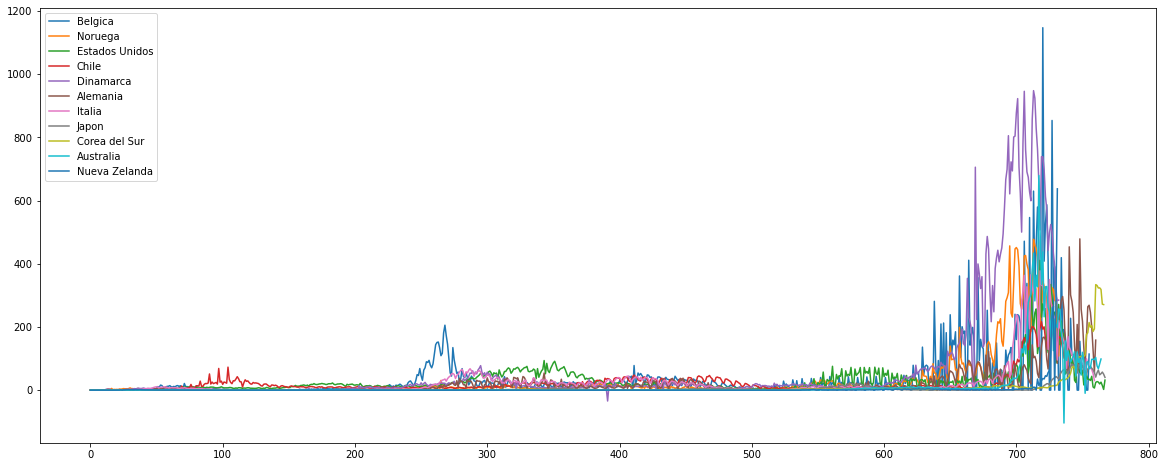

In [5]:
plt.figure(figsize=(20,8))
for j in range(len(Time_series)):
    plt.plot(Time_series[j],label=(Paises[j]))
    plt.legend()

Minima of delayed mutual information = [ 2  8 14 33 38 45 52 59 66 76 88]
Autocorrelation time = 2


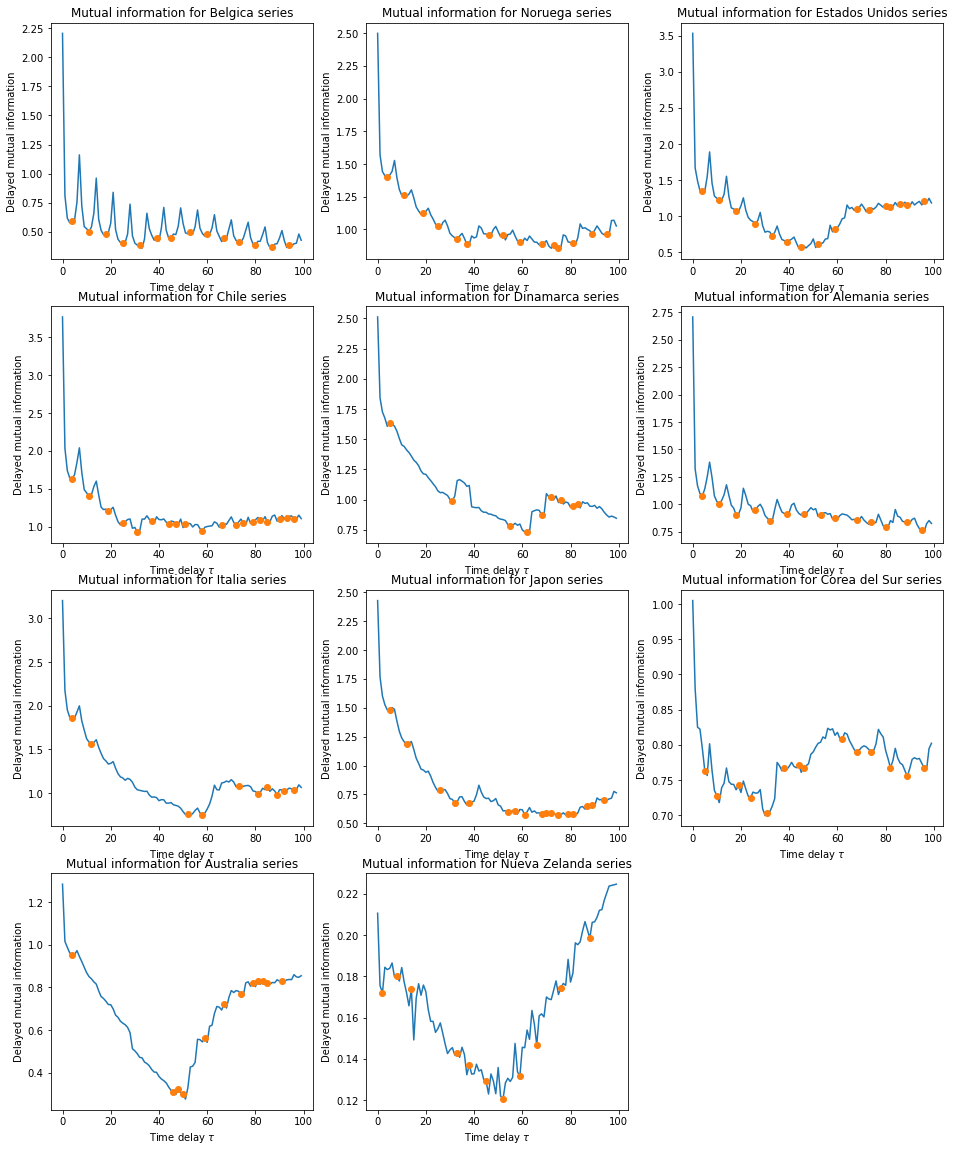

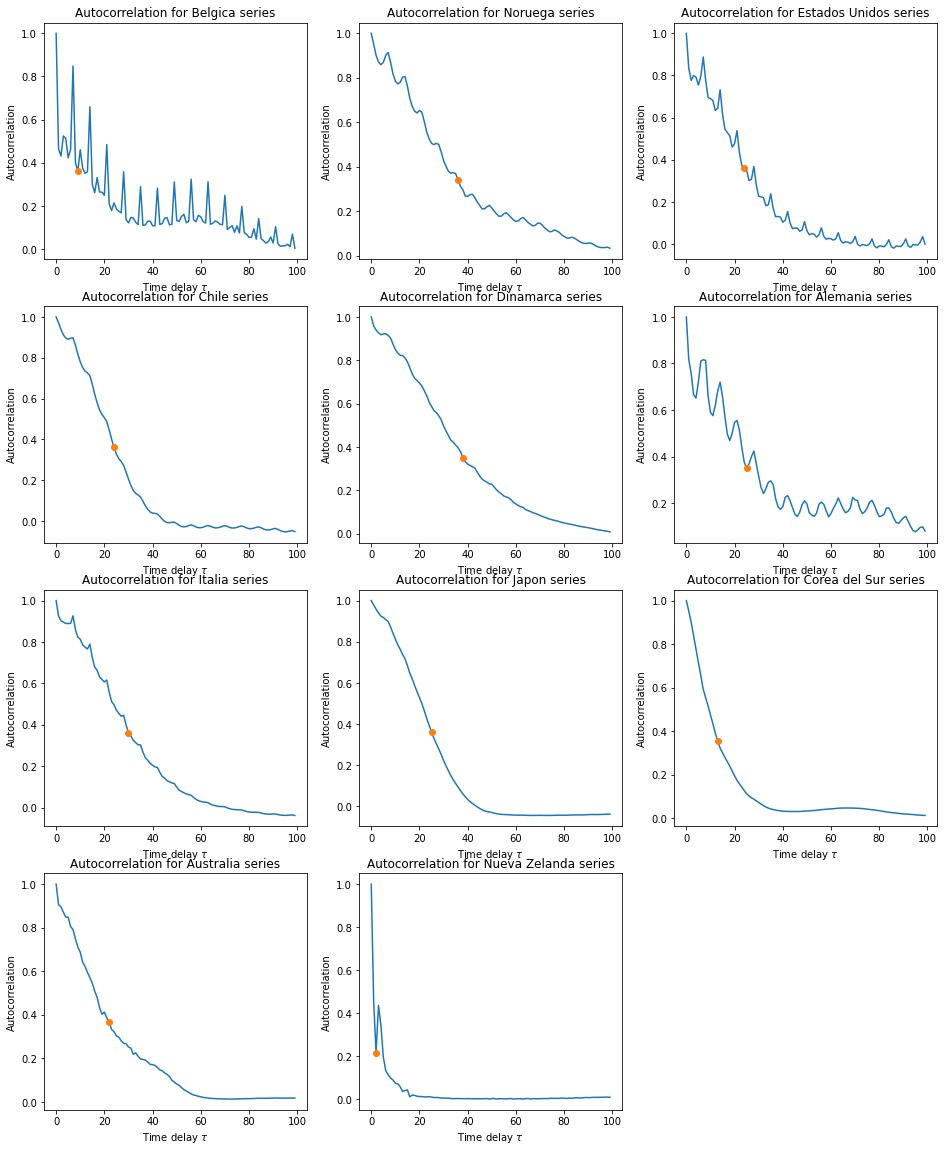

In [6]:
N=len(Time_series)
#Mutual information.
# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
i_delay=np.zeros(N)
r_delay=np.zeros(N)
plt.figure(1,figsize=(16,20))
Minimals=np.zeros(N)
for j in range(N):
    x=Time_series[j]
    i = delay.dmi(x, maxtau=100)
    i_delay = localmin(noise.sma(i, hwin=1)) + 1
    plt.subplot(4,3,0+j+1)
    plt.title(r'Mutual information for ' + str(Paises[j]) +' series')
    plt.ylabel(r'Delayed mutual information')
    plt.xlabel(r'Time delay $\tau$')
    plt.plot(lag, i, i_delay, i[i_delay], 'o')
    Minimals[j]=i_delay[0]
print(r'Minima of delayed mutual information = %s' % i_delay)

#Autocorrelation
Autocorrnumber=np.zeros(N)
plt.figure(2,figsize=(16,20))
for j in range(N):
    x=Time_series[j]
    r = delay.acorr(x, maxtau=100)
    r_delay = np.argmax(r < 1.0 / np.e)
    plt.subplot(4,3,0+j+1)
    plt.title(r'Autocorrelation for ' + str(Paises[j]) +' series')
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'Autocorrelation')
    plt.plot(lag, r, r_delay, r[r_delay], 'o')
    Autocorrnumber[j]=r_delay
print(r'Autocorrelation time = %d' % r_delay)

In [7]:
#Define Tau and Theilers window
Tau=Minimals
Theiler=Autocorrnumber*3
#Corrections
# Tau[-2]=Tau[-3]=Tau[4]=Tau[-1]=5
# Theiler[-1]=75

In [8]:
maxnumb=np.zeros(len(Theiler))
for j in range(len(Theiler)):   
    maxnumb[j]=int(Theiler[j])*2+3

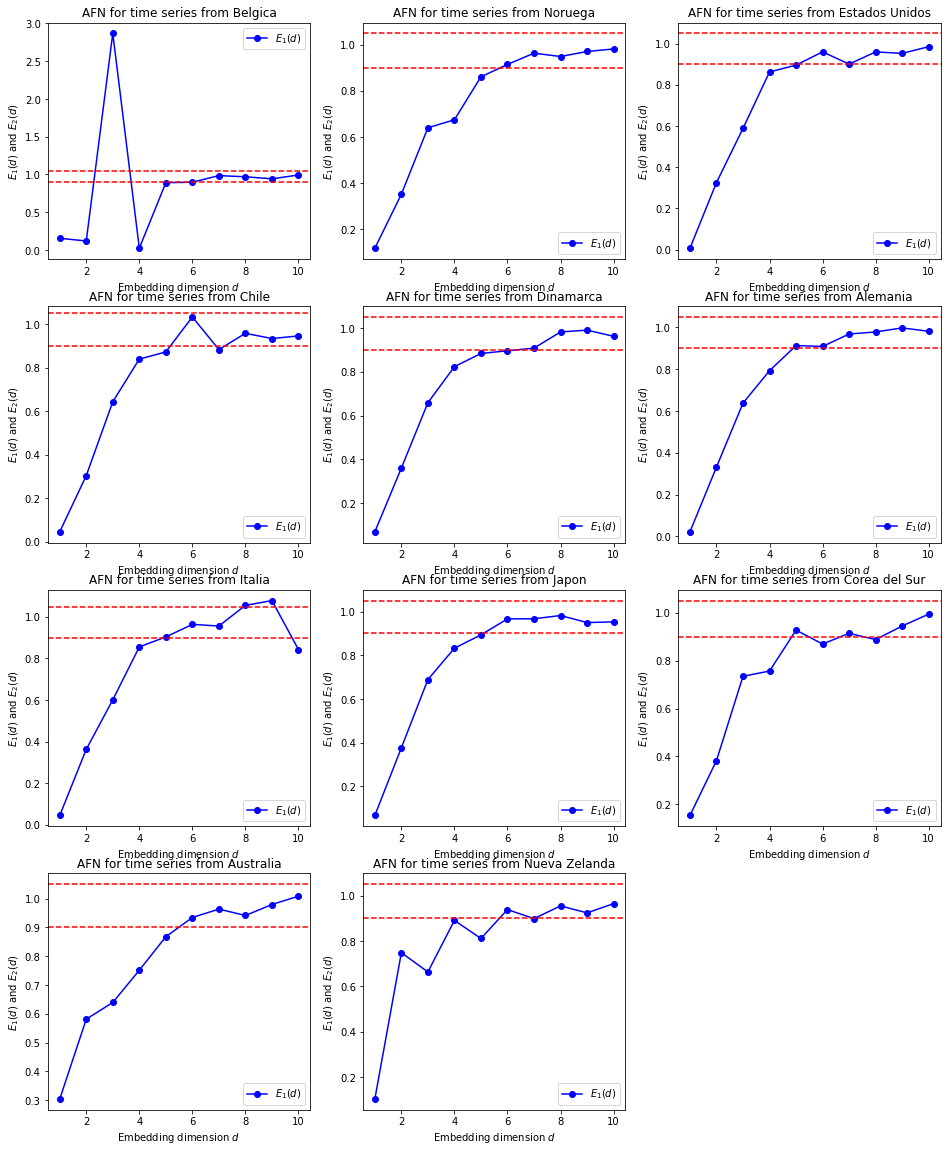

In [9]:
plt.figure(1,figsize=(16,20))
for i in range(N):
    X=Time_series[i]
    # AFN algorithm.
    dim = np.arange(1, 10 + 2)
    E, Es = dimension.afn(X, tau=int(Tau[i]), dim=dim, window=int(Theiler[i]),maxnum=4*60)
    E1, E2 = E[1:] / E[:-1], Es[1:] / Es[:-1]
    plt.subplot(4,3,1+i)
    plt.title(r'AFN for time series from '+Paises[i])
    plt.xlabel(r'Embedding dimension $d$')
    plt.ylabel(r'$E_1(d)$ and $E_2(d)$')
    plt.plot(dim[:-1], E1, 'bo-', label=r'$E_1(d)$')
    plt.axhline(y = 0.9, color = 'r', linestyle = '--')
    plt.axhline(y = 1.05, color = 'r', linestyle = '--')
    #plt.plot(dim[:-1], E2, 'go-', label=r'$E_2(d)$')
    plt.legend()
plt.show()

In [10]:
#Define a vector of the corresponding dimensions to embed
Embdim=[5,6,6,6,7,7,6,6,8,6,7]

In [11]:
def Lyapunov(X,tauu,d,theiler,maxnumb=None):
    MLEs_nolitsa=np.zeros(1)
    #Compute the average divergence for each time up to maxt
    LEs=lyapunov.mle_embed(X, dim=[int(d)], tau=int(tauu), window=int(theiler), maxt=100, maxnum=maxnumb)[0]
    sma=noise.sma(LEs[:40], hwin=0)
    sma=LEs[:40]
    p = np.polyfit(np.arange(len(sma)), sma,deg=1)
    xaxis = np.arange(len(sma))
    yaxis = p[1] + p[0] * xaxis
    #Compute the maximum lyapunov exponent as the slope
    MLEs_nolitsa[0]=p[0]
    return MLEs_nolitsa[0]*365

MLEs_nolitsa=np.zeros(N)
#Compute Lyapunov exponents
for j in range(N):
    MLEs_nolitsa[j]=Lyapunov(Time_series[j],int(Tau[j]),int(Embdim[j]),2*int(Theiler[j]))
MLEs_nolitsa

array([12.58464672,  9.55992366,  9.92803471, 14.95506501,  9.88172515,
       12.86363442, 21.43002453, 20.44308397,  8.34748216, 12.92529475,
               nan])

<BarContainer object of 11 artists>

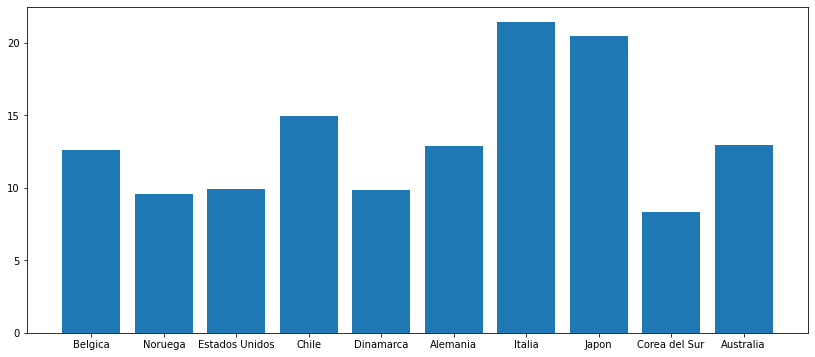

In [12]:
plt.figure(figsize=(14,6))
plt.bar(Paises,MLEs_nolitsa)

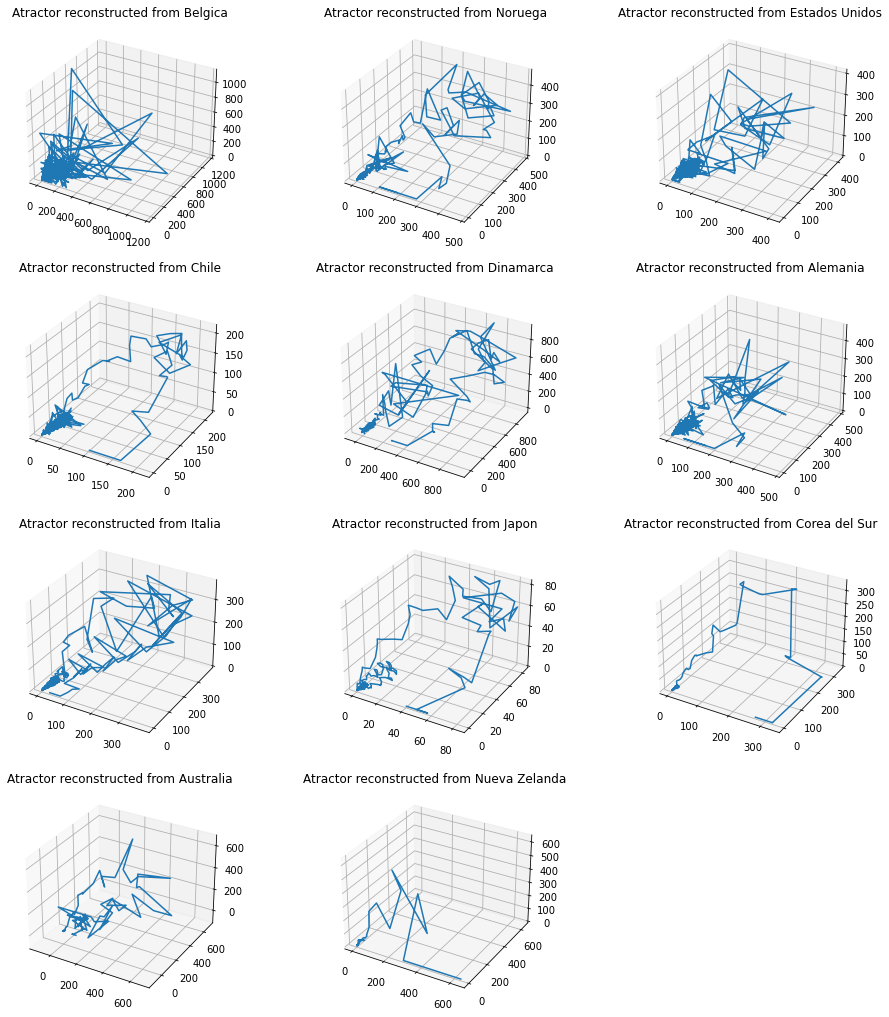

In [13]:
def Atractores(X,tauu,title='Pais'):
    tau_to_use=tauu
    data=X
    data_lag0 = data.flatten()
    data_lag1 = np.roll(data, -tau_to_use).flatten()
    data_lag2 = np.roll(data, -2 * tau_to_use).flatten()
    # Plot time delay embedding
    ax = plt.subplot(4,3,1+j, projection='3d')
    ax.plot3D(data_lag0, data_lag1, data_lag2)
#     ax.view_init(45,45)
    plt.title('Atractor reconstructed from '+ title)

fig = plt.figure(figsize=(16,18))
for j in range(len(Time_series)):
    Atractores(Time_series[j],int(Tau[j]),Paises[j])
plt.show()

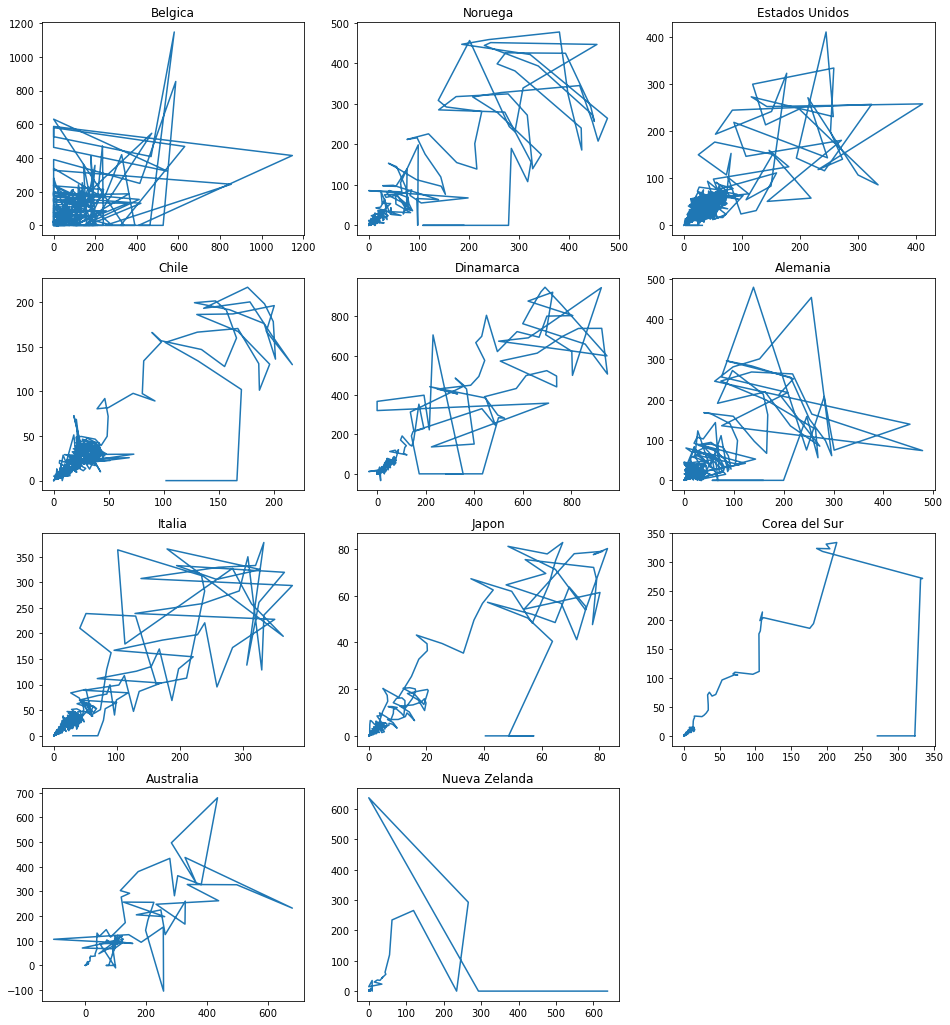

In [14]:
fig = plt.figure(figsize=(16,18))
for j in range(11):
    ax = plt.subplot(4,3,1+j)
    ax.plot(Time_series[j],np.roll(Time_series[j],-int(Tau[j])).flatten())
    plt.title(Paises[j])